In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.stats
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

In [2]:
def macro_recall(confusion_matrix):
    n = 0
    accumulated_recall = 0
    for row in confusion_matrix:
        accumulated_recall += row[n]/np.sum(row)
        n += 1
        
    return accumulated_recall/(n)

In [3]:
sub_LBM = {'38A': 39.47,
           '38B': 62.78,
           '38C': 53.5,
           '38D': 37.47,
           '38E': 45.52,
           '38F': 43.38,
           '38H': 47.39}

sub_BW = {'38A': 70.1,
          '38B': 96.51,
          '38C': 84.4,
          '38D': 65.1,
          '38E': 78.8,
          '38F': 68.4,
          '38H': 88.8}

sub_BMI = {'38A': 30.9,
           '38B': 33.7,
           '38C': 31,
           '38D': 27,
           '38E': 32,
           '38F': 27.9,
           '38H': 29}

sub_FM = {'38A':  26.8371,
           '38B': 28.7399,
           '38C': 24.7426,
           '38D': 26.0123,
           '38E': 32.4202,
           '38F': 23.9422,
           '38H': 39.7503}

In [4]:
########################################################
#raw data
########################################################

#spreadsheet = '../../CGM_insulin_TG_data.xlsx'

def get_raw_data(blood_analyte, spreadsheet):
    #subject_id = '38A'
    #blood_analyte = 'CGM'

    xl = pd.ExcelFile(spreadsheet)
    Meal_dfs = xl.parse(blood_analyte)
    sub_meal_idx = {}

    
    
    
    
    X=[]
    Y1=[]
    Y2=[]
    Y3=[]

    for index, row in Meal_dfs.iterrows():

        #ignore missing meals
        if not math.isnan(row.tolist()[6]):

            #get each subject's meal index
            for subject_id in ['38A', '38B', '38C', '38D', '38E', '38F', '38H']:
                if row['Patient_ID'] == subject_id:
                    if subject_id in sub_meal_idx:
                        sub_meal_idx[subject_id] += [index]
                    else:
                        sub_meal_idx[subject_id] = [index]




        X += [np.float32(one_cgm) for one_cgm in row.tolist()[2:34]]

        #carbs
        if row['Meal_ID'][4]== '1':
            Y1 += [np.float32(52.25)]
            #Y1 += [np.float32(1)]
        elif row['Meal_ID'][4]== '2':
            Y1 += [np.float32(94.75)]
            #Y1 += [np.float32(2)]
        elif row['Meal_ID'][4]== '3':
            Y1 += [np.float32(179.75)]
            #Y1 += [np.float32(3)]

        #protein
        if row['Meal_ID'][1]== '1':
            Y2 += [np.float32(15)]
            #Y2 += [np.float32(1)]
        elif row['Meal_ID'][1]== '2':
            Y2 += [np.float32(30)]
            #Y2 += [np.float32(2)]
        elif row['Meal_ID'][1]== '3':
            Y2 += [np.float32(60)]
            #Y2 += [np.float32(3)]

        #fat
        if row['Meal_ID'][7]== '1':
            Y3 += [np.float32(13)]    
            #Y3 += [np.float32(1)]  
        elif row['Meal_ID'][7]== '2':
            Y3 += [np.float32(26)]   
            #Y3 += [np.float32(2)]  
        elif row['Meal_ID'][7]== '3':
            Y3 += [np.float32(52)]  
            #Y3 += [np.float32(3)]



    X_value = np.array(X).reshape(63,32)
    scaler = StandardScaler()
    #X_value = scaler.fit_transform(X_value)
    Y1_value = np.array(Y1).reshape(-1,1)
    Y2_value = np.array(Y2).reshape(-1,1)
    Y3_value = np.array(Y3).reshape(-1,1)

    #one hot encoding
    s = pd.Series(Y1_value.reshape(63,))
    Y1_value_1hot = pd.get_dummies(s)
    Y1_value_1hot = Y1_value_1hot.values

    s = pd.Series(Y2_value.reshape(63,))
    Y2_value_1hot = pd.get_dummies(s)
    Y2_value_1hot = Y2_value_1hot.values

    s = pd.Series(Y3_value.reshape(63,))
    Y3_value_1hot = pd.get_dummies(s)
    Y3_value_1hot = Y3_value_1hot.values


    #Y1 = (Y1 - Y1.min())/(Y1.max()-Y1.min())
    #Y2 = (Y2 - Y2.min())/(Y2.max()-Y2.min())
    #Y3 = (Y3 - Y3.min())/(Y3.max()-Y3.min())
    

    

    
    return X_value, Y1_value_1hot, Y2_value_1hot, Y3_value_1hot, sub_meal_idx

In [5]:
########################################################
# 17 Gaussian AUC features
########################################################


#data=pd.DataFrame(pd.read_excel('../../CGM_insulin_TG_data.xlsx'))
#feature_num can be 5 or 17

def get_Gau_features(blood_analyte, spreadsheet, feature_num):

    xl = pd.ExcelFile(spreadsheet)
    data = xl.parse(blood_analyte)

    def process_data(data):
        sample_am = data.shape[0]
        #deprecated for these labels
        protein = data.iloc[:, 1].values.reshape(-1, 1)
        cho = data.iloc[:, 2].values.reshape(-1, 1)
        fat = data.iloc[:, 3].values.reshape(-1, 1)
        # pudding_A = data_38A.iloc[:,4].values.reshape(-1,1)
        # water = data_38A.iloc[:,5].values.reshape(-1,1)
        total_e = data.iloc[:, 6].values.reshape(-1, 1)
        glucose = data.iloc[:, 2:35].values.reshape(sample_am, -1)
        #glucose_last_column = glucose[:, -1]
        #glucose_r = np.c_[glucose, glucose_last_column]
        #return protein, cho, fat, total_e, glucose
        return protein, cho, fat, total_e, offset_to_baseline(glucose)

    def offset_to_baseline(a):
        #a = np.array([[1,2,3],[4,5,6]]) 

        averages = np.array([])
        for idx, row in enumerate(a):
            averages = np.append(averages, np.mean(row[:3]))

        averages = averages.reshape(a.shape[0], 1)
        averages_new = np.tile(averages, a.shape[1])

        return a - averages_new

    def process_glucose(glucose, feature_num):
        a = np.zeros((1, 5))
        for row in glucose:
            # print(glucose_gaussian_feature_4(row).shape())
            # print(glucose_gaussian_feature_8(row).shape())
            # print(glucose_gaussian_feature_16(row).shape())
            
            if feature_num == 17:
                glucose_gaussian_feature = np.hstack((glucose_gaussian_feature_4(row),
                                                      glucose_gaussian_feature_8(row),
                                                      glucose_gaussian_feature_16(row)))
            elif feature_num == 5:
                glucose_gaussian_feature = np.hstack((glucose_gaussian_feature_8(row)))
                
            a = np.vstack([a, glucose_gaussian_feature])
        # print(a.shape)
        a = np.delete(a, 0, axis=0)
        # print(a.shape)
        return a

    def normal_function(mu, sigma, x):
        normal_function_value = (1 / (sigma * np.sqrt(2 * np.pi))) * \
            np.exp(-((x - mu) ** 2) / (2 * (sigma ** 2)))
        return normal_function_value

    def glucose_gaussian_feature_4(glucose_row):
        gaussian_feature = []
        normal_g_1 = normal_function(
            0, 4/1.96, np.asarray([i for i in range(0, 5)])) * glucose_row[0:5]
        normal_g_2 = normal_function(
            4, 4/1.96, np.asarray([i for i in range(0, 9)])) * glucose_row[0:9]
        normal_g_3 = normal_function(
            8, 4/1.96, np.asarray([i for i in range(4, 13)])) * glucose_row[4:13]
        normal_g_4 = normal_function(
            12, 4/1.96, np.asarray([i for i in range(8, 17)])) * glucose_row[8:17]
        normal_g_5 = normal_function(
            16, 4/1.96, np.asarray([i for i in range(12, 21)])) * glucose_row[12:21]
        normal_g_6 = normal_function(
            20, 4/1.96, np.asarray([i for i in range(16, 25)])) * glucose_row[16:25]
        normal_g_7 = normal_function(
            24, 4/1.96, np.asarray([i for i in range(20, 29)])) * glucose_row[20:29]
        normal_g_8 = normal_function(
            28, 4/1.96, np.asarray([i for i in range(24, 33)])) * glucose_row[24:33]
        normal_g_9 = normal_function(
            32, 4/1.96, np.asarray([i for i in range(28, 33)])) * glucose_row[28:33]
        for i in range(1, 10):
            gaussian_feature.append(np.trapz(locals()["normal_g_" + str(i)]))
        return gaussian_feature

    def glucose_gaussian_feature_8(glucose_row):
        gaussian_feature = []
        normal_g_1 = normal_function(
            0, 8/1.96, np.asarray([i for i in range(0, 9)])) * glucose_row[0:9]
        normal_g_2 = normal_function(
            8, 8/1.96, np.asarray([i for i in range(0, 17)])) * glucose_row[0:17]
        normal_g_3 = normal_function(
            16, 8/1.96, np.asarray([i for i in range(8, 25)])) * glucose_row[8:25]
        normal_g_4 = normal_function(
            24, 8/1.96, np.asarray([i for i in range(16, 33)])) * glucose_row[16:33]
        normal_g_5 = normal_function(
            32, 8/1.96, np.asarray([i for i in range(24, 33)])) * glucose_row[24:33]
        for i in range(1, 6):
            gaussian_feature.append(np.trapz(locals()["normal_g_" + str(i)]))
        return gaussian_feature

    def glucose_gaussian_feature_16(glucose_row):
        gaussian_feature = []
        normal_g_1 = normal_function(
            0, 16/1.96, np.asarray([i for i in range(0, 17)])) * glucose_row[0:17]
        normal_g_2 = normal_function(
            16, 16/1.96, np.asarray([i for i in range(0, 33)])) * glucose_row[0:33]
        normal_g_3 = normal_function(
            32, 16/1.96, np.asarray([i for i in range(16, 33)])) * glucose_row[16:33]
        for i in range(1, 4):
            gaussian_feature.append(np.trapz(locals()["normal_g_" + str(i)]))
        return gaussian_feature


    p,c,f,e,r=process_data(data)
    newfeature=process_glucose(r, feature_num)

    X_Gau = newfeature

    #X_both = np.hstack((X_value,X_Gau))
    
    return X_Gau

In [6]:
######################################
#training + parameter search
######################################

#return meal prediction, ground truth, and meal score
def ConstructModel_PrintResult(gpu_num, Input_X, Y1_value_1hot, Y2_value_1hot, Y3_value_1hot, 
                               sub, sub_meal_idx, scenario = 'L1MO', N_epochs=55, verbose=True):

    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    device_nb = gpu_num
    os.environ["CUDA_VISIBLE_DEVICES"]=str(device_nb)


    import tensorflow as tf
    import numpy as np

    #Y1=carbs     Y2=protein      Y3=fat


    #options: X_value     X_Gau   X_both
    Input_X = Input_X



    #loss => all default huber

    #choose between L1SO vs. L1MO
    scenario = scenario

    L1MO_test_subs = [sub]

    neuron_shared_ls = [5]

    learning_rate_1_ls = [0.005]

    learning_rate_2_ls = [0.005]

    learning_rate_3_ls = [0.005]

    #5 0.001 0.001 0.005



    N_epochs = N_epochs
    
    #for reproducibility on NN
    np.random.seed(5)

    metrics_CHO = []
    metrics_pro = []
    metrics_fat = []


    #to average the results for a number of runs
    #for num_of_runs in range(30):

    #____________________________________________
    #if not for grid search, can be commented out
    for neurons_shared in neuron_shared_ls:
        for learning_rate_1 in learning_rate_1_ls:
            for learning_rate_2 in learning_rate_2_ls:
                for learning_rate_3 in learning_rate_3_ls:

                    '''
                    neurons_shared = 3
                    learning_rate_1 = 0.001
                    learning_rate_2 = 0.005
                    learning_rate_3 = 0.005
                    '''


                    # ======================
                    # Define the Graph
                    # ======================

                    # Define the Placeholders
                    X = tf.placeholder("float", [None, Input_X.shape[1]], name="X")
                    Y1 = tf.placeholder("float", [None, Y1_value_1hot_.shape[1]], name="Y1")
                    Y2 = tf.placeholder("float", [None, Y2_value_1hot_.shape[1]], name="Y2")
                    Y3 = tf.placeholder("float", [None, Y3_value_1hot_.shape[1]], name="Y3")

                    # Initial random weights for the layers
                    #shared layer weights
                    initial_shared_layer_weights = np.random.rand(Input_X.shape[1],neurons_shared)
                    #print(initial_shared_layer_weights)
                    initial_Y1_layer_weights = np.random.rand(neurons_shared, Y1_value_1hot_.shape[1])
                    #print(initial_Y1_layer_weights)
                    initial_Y2_layer_weights = np.random.rand(neurons_shared, Y2_value_1hot_.shape[1])
                    #print(initial_Y2_layer_weights)
                    initial_Y3_layer_weights = np.random.rand(neurons_shared, Y3_value_1hot_.shape[1])
                    #print(initial_Y3_layer_weights)

                    #define the variable objects for the weights
                    shared_layer_weights = tf.Variable(initial_shared_layer_weights, name="share_W", dtype="float32")
                    Y1_layer_weights = tf.Variable(initial_Y1_layer_weights, name="share_Y1", dtype="float32")
                    Y2_layer_weights = tf.Variable(initial_Y2_layer_weights, name="share_Y2", dtype="float32")
                    Y3_layer_weights = tf.Variable(initial_Y3_layer_weights, name="share_Y3", dtype="float32")



                    #Define the biases for the layers
                    #shared layer bias
                    initial_shared_layer_bias = np.random.rand(neurons_shared,)
                    #print('bias')
                    #print(initial_shared_layer_bias)
                    initial_Y1_layer_bias = np.random.rand(Y1_value_1hot_.shape[1])
                    #print(initial_Y1_layer_bias)
                    initial_Y2_layer_bias = np.random.rand(Y2_value_1hot_.shape[1])
                    #print(initial_Y2_layer_bias)
                    initial_Y3_layer_bias = np.random.rand(Y3_value_1hot_.shape[1])
                    #print(initial_Y3_layer_bias)

                    shared_layer_bias = tf.Variable(initial_shared_layer_bias, name="share_B", dtype="float32")
                    Y1_layer_bias = tf.Variable(initial_Y1_layer_bias, name="share_Y1_B", dtype="float32")
                    Y2_layer_bias = tf.Variable(initial_Y2_layer_bias, name="share_Y2_B", dtype="float32")
                    Y3_layer_bias = tf.Variable(initial_Y3_layer_bias, name="share_Y3_B", dtype="float32")



                    # Construct the Layers with RELU Activations
                    shared_layer = tf.nn.relu(tf.add(tf.matmul(X,shared_layer_weights), shared_layer_bias))
                    #Y1_layer = tf.nn.relu(tf.add(tf.matmul(shared_layer,Y1_layer_weights), Y1_layer_bias))
                    #Y2_layer = tf.nn.relu(tf.add(tf.matmul(shared_layer,Y2_layer_weights), Y2_layer_bias))
                    #Y3_layer = tf.nn.relu(tf.add(tf.matmul(shared_layer,Y3_layer_weights), Y3_layer_bias))
                    Y1_layer = tf.add(tf.matmul(shared_layer,Y1_layer_weights), Y1_layer_bias)
                    Y2_layer = tf.add(tf.matmul(shared_layer,Y2_layer_weights), Y2_layer_bias)
                    Y3_layer = tf.add(tf.matmul(shared_layer,Y3_layer_weights), Y3_layer_bias)




                    # Calculate Loss
                    #Y1_Loss = tf.nn.l2_loss(Y1-Y1_layer)
                    #Y1_Loss = tf.norm(Y1-Y1_layer, ord= 1)
                    #Y1_Loss = tf.losses.mean_squared_error(Y1, Y1_layer)
                    #Y1_Loss = tf.losses.huber_loss(Y1, Y1_layer)
                    #Y1_Loss = tf.keras.losses.logcosh(Y1, Y1_layer)
                    Y1_Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y1_layer, labels=Y1))

                    #Y2_Loss = tf.nn.l2_loss(Y2-Y2_layer)
                    #Y2_Loss = tf.norm(Y2-Y2_layer, ord= 1)
                    #Y2_Loss = tf.losses.mean_squared_error(Y2, Y2_layer)
                    #Y2_Loss = tf.losses.huber_loss(Y2, Y2_layer)
                    Y2_Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y2_layer, labels=Y2))

                    #Y3_Loss = tf.nn.l2_loss(Y3-Y3_layer)
                    #Y3_Loss = tf.norm(Y3-Y3_layer, ord= 1)
                    #Y3_Loss = tf.losses.mean_squared_error(Y3, Y3_layer)
                    #Y3_Loss = tf.losses.huber_loss(Y3, Y3_layer)
                    Y3_Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Y3_layer, labels=Y3))

                    Joint_Loss = Y1_Loss + Y2_Loss + Y3_Loss

                    # optimisers
                    Optimiser = tf.train.AdamOptimizer().minimize(Joint_Loss)
                    Y1_op = tf.train.AdamOptimizer(learning_rate=learning_rate_1, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(Y1_Loss)
                    Y2_op = tf.train.AdamOptimizer(learning_rate=learning_rate_2, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(Y2_Loss)
                    Y3_op = tf.train.AdamOptimizer(learning_rate=learning_rate_3, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(Y3_Loss)










                    #__________________________________________________________________________________________________________
                    # Joint Training
                    # Calculation (Session) Code
                    # ==========================

                    # open the session
                    session = tf.InteractiveSession()




                    ################################ L1SO #####################################################################
                    if scenario == 'L1SO':

                        sub_to_correlation = {}


                        for test_sub in ['38A', '38B', '38C', '38D', '38E', '38F', '38H']: 


                            if test_sub not in sub_to_correlation:
                                sub_to_correlation[test_sub] = {}


                            Y1_loss_list = []
                            Y2_loss_list = []
                            Y3_loss_list = []
                            Joint_loss_list = []


                            session.run(tf.global_variables_initializer())


                            #######  training phase  ###########
                            for i in range(1, N_epochs):


                                train_meal_idx = []
                                for one_sub in sub_meal_idx:
                                    if one_sub != test_sub:
                                        train_meal_idx += sub_meal_idx[one_sub]

                                random.shuffle(train_meal_idx)


                                #each meal will be one batch, and only update one out of three loss
                                for meal_idx in train_meal_idx:
                                    rand_nb = np.random.rand()
                                    if rand_nb < 0.25:
                                        _, Y1_loss = session.run([Y1_op, Y1_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[meal_idx, :].reshape(-1,3)
                                                          })

                                        Y1_loss_list += [float(str(Y1_loss))]

                                    elif 0.25 <= rand_nb < 0.5:
                                        _, Y2_loss = session.run([Y2_op, Y2_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[meal_idx, :].reshape(-1,3)
                                                          })

                                        Y2_loss_list += [float(str(Y2_loss))]

                                    elif 0.5 <= rand_nb < 0.75:
                                        _, Y3_loss = session.run([Y3_op, Y3_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[meal_idx, :].reshape(-1,3)
                                                          })

                                        Y3_loss_list += [float(str(Y3_loss))]

                                    else:
                                        _, Joint_loss = session.run([Optimiser, Joint_Loss],
                                                        {
                                                          X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[meal_idx, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[meal_idx, :].reshape(-1,3)
                                                          })
                                        Joint_loss_list += [float(str(Joint_loss))]



                                if i % 2000 == 0:
                                    print('y1 loss: ', Y1_loss, end=' |')
                                    print('y2 loss: ', Y2_loss, end=' |')
                                    print('y3 loss: ', Y3_loss, end=' |')
                                    print('joint loss: ', Joint_loss)



                            #######  testing phase  ###########
                            all_pred = []
                            all_true = []

                            for test_meal in sub_meal_idx[test_sub]:
                                Y1_pred, Y2_pred, Y3_pred = session.run([Y1_layer,Y2_layer,Y3_layer], {
                                                      X: Input_X[test_meal].reshape(-1,Input_X.shape[1]),
                                                      Y1: Y1_value_1hot[test_meal].reshape(-1,3),
                                                      Y2: Y2_value_1hot[test_meal].reshape(-1,3),
                                                      Y3: Y3_value_1hot[test_meal].reshape(-1,3)
                                                      })
                                all_pred += [[np.argmax(Y1_pred[0]), np.argmax(Y2_pred[0]), np.argmax(Y3_pred[0])]]
                                all_true += [[np.argmax(Y1_value_1hot[test_meal]), np.argmax(Y2_value_1hot[test_meal]), np.argmax(Y3_value_1hot[test_meal])]]



                            #######  plotting phase  ###########
                            corr_cx = []
                            corr_cy = []
                            corr_px = []
                            corr_py = []
                            corr_fx = []
                            corr_fy = []


                            for meal_num in range(len(all_true)):
                                corr_cx.append(all_pred[meal_num][0])
                                corr_cy.append(all_true[meal_num][0])

                                corr_px.append(all_pred[meal_num][1])
                                corr_py.append(all_true[meal_num][1])

                                corr_fx.append(all_pred[meal_num][2])
                                corr_fy.append(all_true[meal_num][2])    

                            sub_to_correlation[test_sub] = {'c':accuracy_score(corr_cx,corr_cy),
                                                            'p':accuracy_score(corr_px,corr_py),
                                                            'f':accuracy_score(corr_fx,corr_fy)}




                            '''
                            plt.subplot(411)
                            plt.plot(Y1_loss_list)
                            plt.subplot(412)
                            plt.plot(Y2_loss_list)
                            plt.subplot(413)
                            plt.plot(Y3_loss_list)
                            plt.subplot(414)
                            plt.plot(Joint_loss_list)
                            plt.show()
                            '''

                            print(test_sub[-1]+'_CHO = ',corr_cx)
                            print('truth_'+test_sub[-1]+'_CHO = ',corr_cy)
                            print(test_sub[-1]+'_pro = ',corr_px)
                            print('truth_'+test_sub[-1]+'_pro = ',corr_py)
                            print(test_sub[-1]+'_fat = ',corr_fx)
                            print('truth_'+test_sub[-1]+'_fat = ',corr_fy)


                        print(neurons_shared, learning_rate_1, learning_rate_2, learning_rate_3) 
                        print(sub_to_correlation)


                        print(max(Y1_loss_list))
                        print(max(Y2_loss_list))  
                        print(max(Y3_loss_list))



                    ################################## L1MO #####################################################################       
                    elif scenario == 'L1MO':

                        sub_to_correlation = {}

                        #for test_sub in ['38A', '38B', '38C', '38D', '38E', '38F', '38H']: 
                        #for test_sub in ['38B']: 
                        for test_sub in L1MO_test_subs:

                            
                            test_sub_BW = sub_BW[test_sub]
                            test_sub_BMI = sub_BMI[test_sub]
                            test_sub_LBM = sub_LBM[test_sub]
                            test_sub_FM = sub_FM[test_sub]
                            
                            test_sub_demo_info = [test_sub_BW, test_sub_BMI, test_sub_LBM, test_sub_FM]
                            
                            if test_sub not in sub_to_correlation:
                                 sub_to_correlation[test_sub] = {}


                            Y1_loss_list = []
                            Y2_loss_list = []
                            Y3_loss_list = []
                            Joint_loss_list = []

                            session.run(tf.global_variables_initializer())

                            #For calculating AUC purpose
                            all_meal_score = []

                            all_meal_pred = []
                            all_meal_true = []

                            for test_meal in sub_meal_idx[test_sub]:

                                #create training indexes
                                train_meal_idxes = []
                                for meal_index in sub_meal_idx[test_sub]:
                                    if meal_index != test_meal:
                                        train_meal_idxes.append(meal_index) 

                                print(test_sub, test_meal, train_meal_idxes)
                                #random.shuffle(train_meal_idxes)


                                #######  training phase  ###########
                                for i in range(1,N_epochs):
                                    for meal_idx in train_meal_idxes:

                                        rand_nb = np.random.rand()
                                        #if rand_nb < 0.333:
                                        _, Y1_loss = session.run([Y1_op, Y1_Loss],
                                                        {
                                                          X: Input_X[train_meal_idxes, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[train_meal_idxes, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[train_meal_idxes, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[train_meal_idxes, :].reshape(-1,3)
                                                          })

                                        Y1_loss_list += [float(str(Y1_loss))]

                                        #elif 0.333 <= rand_nb < 0.666:
                                        _, Y2_loss = session.run([Y2_op, Y2_Loss],
                                                        {
                                                          X: Input_X[train_meal_idxes, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[train_meal_idxes, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[train_meal_idxes, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[train_meal_idxes, :].reshape(-1,3)
                                                          })

                                        Y2_loss_list += [float(str(Y2_loss))]

                                        #elif 0.666 <= rand_nb < 0.999:
                                        _, Y3_loss = session.run([Y3_op, Y3_Loss],
                                                        {
                                                          X: Input_X[train_meal_idxes, :].reshape(-1,Input_X.shape[1]),
                                                          Y1: Y1_value_1hot[train_meal_idxes, :].reshape(-1,3),
                                                          Y2: Y2_value_1hot[train_meal_idxes, :].reshape(-1,3),
                                                          Y3: Y3_value_1hot[train_meal_idxes, :].reshape(-1,3)
                                                          })

                                        Y3_loss_list += [float(str(Y3_loss))]

                                        '''    
                                        else:
                                            _, Joint_loss = session.run([Optimiser, Joint_Loss],
                                                            {
                                                              X: Input_X[meal_idx, :].reshape(-1,Input_X.shape[1]),
                                                              Y1: Y1_value[meal_idx, :].reshape(-1,1),
                                                              Y2: Y2_value[meal_idx, :].reshape(-1,1),
                                                              Y3: Y3_value[meal_idx, :].reshape(-1,1)
                                                              })
                                            Joint_loss_list += [float(str(Joint_loss))]
                                        '''


                                if i % 50 == 0:
                                    print('y1 loss: ', Y1_loss, end=' |')
                                    print('y2 loss: ', Y2_loss, end=' |')
                                    print('y3 loss: ', Y3_loss, end=' |')
                                    print('joint loss: ', Joint_loss)



                                #######  testing phase  ###########
                                Y1_pred, Y2_pred, Y3_pred = session.run([Y1_layer,Y2_layer,Y3_layer], {
                                                      X: Input_X[test_meal].reshape(-1,Input_X.shape[1]),
                                                      Y1: Y1_value_1hot[test_meal].reshape(-1,3),
                                                      Y2: Y2_value_1hot[test_meal].reshape(-1,3),
                                                      Y3: Y3_value_1hot[test_meal].reshape(-1,3)
                                                      })
                                
                                
                                all_meal_score += [[Y1_pred[0], Y2_pred[0], Y3_pred[0]]]
                                all_meal_pred += [[np.argmax(Y1_pred[0]), np.argmax(Y2_pred[0]), np.argmax(Y3_pred[0])]]
                                all_meal_true += [[np.argmax(Y1_value_1hot[test_meal]), np.argmax(Y2_value_1hot[test_meal]), np.argmax(Y3_value_1hot[test_meal])]]



                            #######  plotting phase  ###########
                            corr_cx = []
                            corr_cy = []
                            corr_px = []
                            corr_py = []
                            corr_fx = []
                            corr_fy = []


                            for meal_num in range(len(all_meal_true)):
                                corr_cx.append(all_meal_pred[meal_num][0])
                                corr_cy.append(all_meal_true[meal_num][0])

                                corr_px.append(all_meal_pred[meal_num][1])
                                corr_py.append(all_meal_true[meal_num][1])

                                corr_fx.append(all_meal_pred[meal_num][2])
                                corr_fy.append(all_meal_true[meal_num][2])    

                            sub_to_correlation[test_sub] = {'c':macro_recall(confusion_matrix(corr_cy, corr_cx)),
                                                            'p':macro_recall(confusion_matrix(corr_py, corr_px)),
                                                            'f':macro_recall(confusion_matrix(corr_fy, corr_fx))}




                            plt.subplot(411)
                            plt.plot(Y1_loss_list)
                            plt.subplot(412)
                            plt.plot(Y2_loss_list)
                            plt.subplot(413)
                            plt.plot(Y3_loss_list)
                            plt.subplot(414)
                            plt.plot(Joint_loss_list)
                            plt.show()


                        print(neurons_shared, learning_rate_1, learning_rate_2, learning_rate_3)    
                        print(sub_to_correlation)

                        print('c')
                        print(corr_cx, corr_cy)
                        print(confusion_matrix(corr_cy, corr_cx))
                        print('p')
                        print(corr_px, corr_py)
                        print(confusion_matrix(corr_py, corr_px))
                        print('f')
                        print(corr_fx, corr_fy) 
                        print(confusion_matrix(corr_fy, corr_fx))

                        metrics_CHO.append(macro_recall(confusion_matrix(corr_cy, corr_cx)))
                        metrics_pro.append(macro_recall(confusion_matrix(corr_py, corr_px)))
                        metrics_fat.append(macro_recall(confusion_matrix(corr_fy, corr_fx)))



                        #print(max(Y1_loss_list))
                        #print(max(Y2_loss_list))  
                        #print(max(Y3_loss_list))


    print(metrics_CHO, metrics_pro, metrics_fat)

    all_meal_score = np.asarray(all_meal_score)
    all_meal_true = np.asarray(all_meal_true)
    
    return all_meal_score, all_meal_pred, all_meal_true, session


In [14]:
session.close()
from numba import cuda
cuda.select_device(0)
cuda.close()

# evaluation functions

In [7]:
def Evaluation_results(all_meal_score, all_meal_true, component = 0):

    def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference


    #change logit number to probability
    def row_wise_softmax(all_meal_score):
        y_score = []

        for row in all_meal_score[:,0,:]:
            y_score.append(softmax(row))

        y_score = np.asarray(y_score)

        return y_score



    #carb: 0    protein: 1     fat:2
    def dummify_one_component(all_meal_true, component = 0):

        if all_meal_true.ndim >= 2:

            y_test = label_binarize(all_meal_true[:,component], classes=np.unique(all_meal_true[:,component]))

        else:

            y_test

        return y_test
    
    
    #prepare labels and proba for one of the components
    y_score = row_wise_softmax(all_meal_score)
    y_test = dummify_one_component(all_meal_true, component)
    
    return y_score, y_test

# run all experiment in one line

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

38H 54 [55, 56, 58, 59, 61, 62]
38H 55 [54, 56, 58, 59, 61, 62]
38H 56 [54, 55, 58, 59, 61, 62]
38H 58 [54, 55, 56, 59, 61, 62]
38H 59 [54, 55, 56, 58, 61, 62]
38H 61 [54, 55, 56, 58, 59, 62]
38H 62 [54, 55, 56, 58, 59, 61]


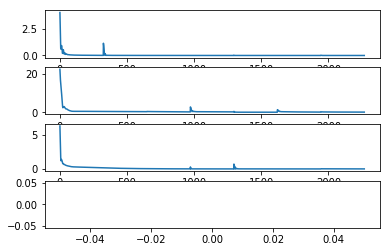

5 0.005 0.005 0.005
{'38H': {'c': 0.6666666666666666, 'p': 0.4166666666666667, 'f': 0.7222222222222222}}
c
[1, 1, 2, 2, 1, 1, 1] [0, 1, 2, 2, 1, 1, 1]
[[0 1 0]
 [0 4 0]
 [0 0 2]]
p
[0, 2, 1, 2, 1, 2, 1] [0, 1, 2, 1, 2, 1, 1]
[[1 0 0]
 [0 1 3]
 [0 2 0]]
f
[0, 1, 1, 2, 1, 2, 0] [0, 1, 2, 1, 1, 2, 0]
[[2 0 0]
 [0 2 1]
 [0 1 1]]
[0.6666666666666666] [0.4166666666666667] [0.7222222222222222]


In [8]:
blood_analyte = 'CGM'
spreadsheet = '../../CGM_insulin_TG_data.xlsx'


#get data with different options
X_value, Y1_value_1hot_, Y2_value_1hot_, Y3_value_1hot_, sub_meal_idx = get_raw_data(blood_analyte, spreadsheet)

X_Gau = get_Gau_features(blood_analyte, spreadsheet, feature_num=5)

sub = '38H'

#which component to plot
#0: carb  1: protein  2: fat
component = 2

#train/build model with different options
all_meal_score, all_meal_pred, all_meal_true, session = ConstructModel_PrintResult(gpu_num=0, 
                                                                                   Input_X=X_Gau,  #X_Gau or X_value
                                                                                   Y1_value_1hot = Y1_value_1hot_,
                                                                                   Y2_value_1hot = Y2_value_1hot_,
                                                                                   Y3_value_1hot = Y3_value_1hot_,
                                                                                   sub=sub, 
                                                                                   sub_meal_idx=sub_meal_idx,
                                                                                   scenario = 'L1MO',#'L1MO' or 'L1SO'
                                                                                   N_epochs=55,
                                                                                   verbose=True)

In [9]:
#perdicted scores and ground truth
#component = 0 carb, 1 protein, 2 fat
y_score_c, y_test_c = Evaluation_results(all_meal_score, all_meal_true, component = 0)

y_score_p, y_test_p = Evaluation_results(all_meal_score, all_meal_true, component = 1)

y_score_f, y_test_f = Evaluation_results(all_meal_score, all_meal_true, component = 2)

In [10]:
y_test_c

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [11]:
from sklearn.metrics import roc_auc_score

average = 'micro'
print('sklearn '+ average + ' AUROC')
print('carbs:', roc_auc_score(y_test_c, y_score_c, average=average))
print('protein:', roc_auc_score(y_test_p, y_score_p, average=average))
print('fat:', roc_auc_score(y_test_f, y_score_f, average=average))


#macro: Calculate metrics for each label, and find their unweighted mean. So different my method
#micro: same results

sklearn micro AUROC
carbs: 0.9489795918367346
protein: 0.8265306122448979
fat: 0.8163265306122448


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


def plot_AUROC_one_component(y_score, y_test, component):

    n_classes = y_test.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        #fpr
        #array([0. , 0. , 0.5, 0.5, 1. ])
        
        roc_auc[i] = auc(fpr[i], tpr[i])

        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    #fpr,         tpr,         threshold
    
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='cornflowerblue',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if component == 0:
        comp = 'CHO'
    elif component == 1:
        comp = 'protein'
    elif component == 2:
        comp = 'fat'
    plt.title('AUROC to %s multi-class prediction for %s'%(comp, sub))
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, roc_auc

In [13]:
y_test

NameError: name 'y_test' is not defined

In [ ]:
#plot one of the classes in one component

#carb: 0 , protein: 1 , fat: 2 
component = component

if component == 0:
    y_score = y_score_c
    y_test = y_test_c
elif component == 1:
    y_score = y_score_p
    y_test = y_test_p
elif component == 2:
    y_score = y_score_f
    y_test = y_test_f



fpr, tpr, roc_auc = plot_AUROC_one_component(y_score, y_test, component = component)

In [ ]:
roc_auc

In [ ]:
session.close()
from numba import cuda
cuda.select_device(0)
cuda.close()